In [1]:
import copy, random
import numpy as np
from pmagpy import ipmag
import pygplates as pygp
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt

import auxiliary_functions as af

### Set variables for synthetic rotation history

In [2]:
#set random seed
seed = 21              
np.random.seed(seed)   

# arbitrary plate ids and plate centroid locations
pltids = [20, 30, 40]
clocs = [[77, -30], [-3, 0], [31, 35]]
colors = ['dodgerblue', 'orange', 'red']

# time range (in Ma)
time_range = 51
time_step = 1

# range of change points over time range
min_cpts = 2    # inclusive in range
max_cpts = 10   # exclusive in range

# minimum euler pole distance from plate centroid (in degrees)
min_dist = 30

# range of plate velocities (mm/yr) and multiplying factor for fast plates
min_vel = 20    # inclusive in range
max_vel = 100   # exclusive in range
faster = 2.5

# polygon file (if desired)
plt_polygons = pygp.FeatureCollection('arbitrary_polygons.gpml')

#fig panel sizes
fsize = (7, 3.5)

### Generate synthetic rotation history

In [3]:
base_rot_model = []
fast_rot_model = []

for i in range(len(pltids)):

    # determine number of changepoints
    num_cpts = np.random.randint(min_cpts, max_cpts)

    # assign times to the changepoints
    cpt_ages = np.sort(np.append(np.random.choice(range(1, time_range-1), num_cpts, replace=False), (0, time_range)))

    # generate synthetic Euler poles
    epoles, omegas = af.generate_epoles(cpt_ages, min_vel, max_vel, min_dist)
    
    # assemble Euler poles into rotation model
    epole_seq = af.assemble_rotations(clocs[i], epoles, omegas)
    for j in range(len(cpt_ages)):
        base_rot_model.append([pltids[i], cpt_ages[j], epole_seq[j][0], epole_seq[j][1], epole_seq[j][2], 1])
        
    # repeat for 'fast plates' alternative model
    fast_omegas = [x * faster for x in omegas]
    epole_seq = af.assemble_rotations(clocs[i], epoles, fast_omegas)
    for j in range(len(cpt_ages)):
        fast_rot_model.append([pltids[i], cpt_ages[j], epole_seq[j][0], epole_seq[j][1], epole_seq[j][2], 0])
        
# write-out base plate rotation model
with open('rot_models/base_rot_model.rot', 'w') as f:
    for entry in base_rot_model:
        f.write("%s\n" % ' '.join(map(str, entry)))
        
# write-out fast plate rotation model
with open('rot_models/fast_rot_model.rot', 'w') as f:
    for entry in fast_rot_model:
        f.write("%s\n" % ' '.join(map(str, entry)))

### Calculate drift and apparent polar wander rates

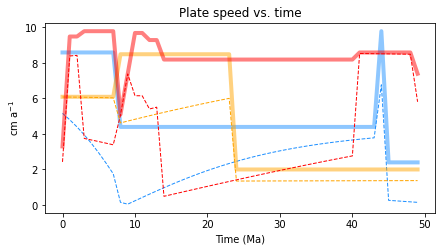

In [4]:
# re-import base rotation model
rotation_model = pygp.RotationModel('rot_models/base_rot_model.rot', default_anchor_plate_id=1)

# generate motion paths and compute plate drift rates
fig = plt.figure(figsize=fsize)
base_motion_paths = []
for i in range(len(pltids)):
    base_motion_path = af.get_motion_path(time_range, time_step, pltids[i], clocs[i], rotation_model)
    base_motion_paths.append(base_motion_path)
    base_full_rates, base_lat_rates = [], []
    for j in range(len(base_motion_path)-1):
        base_full_rates.append(af.get_gcd(base_motion_path[j], base_motion_path[j+1]) * 111 / (10*time_step)) # get gcd and convert from deg/Ma to cm/yr
        base_lat_rates.append(abs(base_motion_path[j][0]-base_motion_path[j+1][0]) * 111 / (10*time_step))
    
    plt.plot(base_full_rates, linestyle='solid', color=colors[i], linewidth=4, alpha=0.5)
    plt.plot(base_lat_rates, linestyle='dashed', color=colors[i], linewidth=1)
    plt.title('Plate speed vs. time')
    plt.ylabel('cm a$^{-1}$')
    plt.xlabel('Time (Ma)')
    
plt.show()

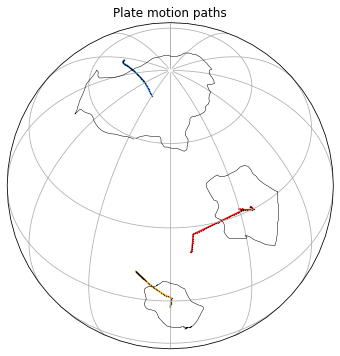

In [5]:
af.plot_motion_paths(central_lon=0, central_lat=45, polygons=plt_polygons, paths=base_motion_paths, colors=colors, title='Plate motion paths')

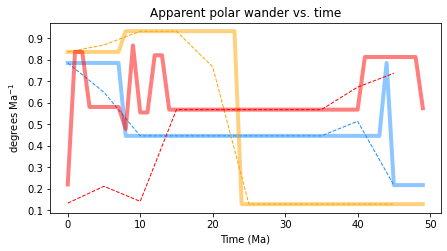

In [6]:
# generate apwps and compute apw rates
fig = plt.figure(figsize=fsize)
base_apwps, base_A95_paths = [], []
for i in range(len(pltids)):
    base_apwp = af.get_apwp(time_range, time_step, pltids[i], rotation_model)
    base_apwps.append(base_apwp)
    base_apw_rates, base_low_res_rates, base_avg_ages = [], [], []
    for j in range(len(base_apwp)-1):
        base_apw_rates.append(af.get_gcd(base_apwp[j], base_apwp[j+1])) # report in deg/Ma
    
    resolution = 5
    base_low_res_apwp = base_apwp[0::resolution]
    base_A95_paths.append(base_low_res_apwp)
    
    for j in range(len(base_low_res_apwp)-1):
        base_low_res_rates.append(af.get_gcd(base_low_res_apwp[j], base_low_res_apwp[j+1]) / resolution)  # report in deg/Ma
        base_avg_ages.append(j*resolution)
        
    plt.plot(base_apw_rates, linestyle='solid', color=colors[i], linewidth=4, alpha=0.5)
    plt.plot(base_avg_ages, base_low_res_rates, linestyle='dashed', color=colors[i], linewidth=1)
    plt.title('Apparent polar wander vs. time')
    plt.ylabel('degrees Ma$^{-1}$')
    plt.xlabel('Time (Ma)')
    
plt.show()

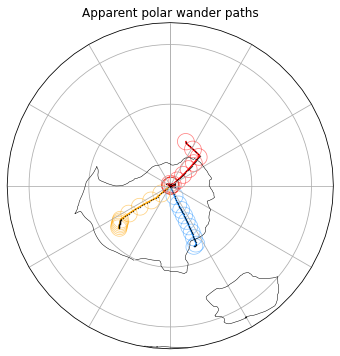

In [7]:
af.plot_apwps(central_lon=0, central_lat=90, polygons=plt_polygons, paths=base_apwps, A95s=base_A95_paths, colors=colors, title='Apparent polar wander paths')

### Ultra-fast plates

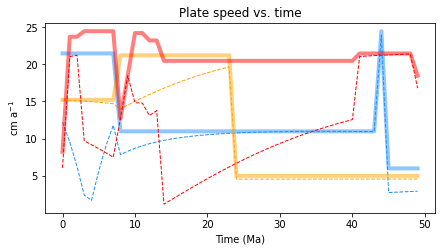

In [8]:
# re-import rotation model
rotation_model = pygp.RotationModel('rot_models/fast_rot_model.rot', default_anchor_plate_id=0)

# generate motion paths and compute plate drift rates
fig = plt.figure(figsize=fsize)
fast_motion_paths = []
for i in range(len(pltids)):
    fast_motion_path = af.get_motion_path(time_range, time_step, pltids[i], clocs[i], rotation_model)
    fast_motion_paths.append(fast_motion_path)
    fast_full_rates, fast_lat_rates = [], []
    for j in range(len(fast_motion_path)-1):
        fast_full_rates.append(af.get_gcd(fast_motion_path[j], fast_motion_path[j+1]) * 111 / (10*time_step)) # get gcd and convert from deg/Ma to cm/yr
        fast_lat_rates.append(abs(fast_motion_path[j][0]-fast_motion_path[j+1][0]) * 111 / (10*time_step))
    
    plt.plot(fast_full_rates, linestyle='solid', color=colors[i], linewidth=4, alpha=0.5)
    plt.plot(fast_lat_rates, linestyle='dashed', color=colors[i], linewidth=1)
    plt.title('Plate speed vs. time')
    plt.ylabel('cm a$^{-1}$')
    plt.xlabel('Time (Ma)')
    
plt.show()

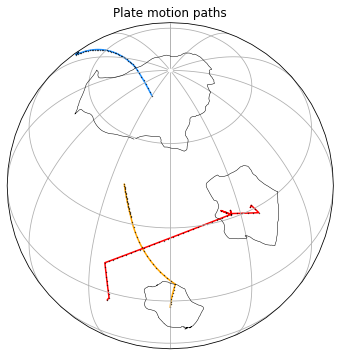

In [9]:
af.plot_motion_paths(central_lon=0, central_lat=45, polygons=plt_polygons, paths=fast_motion_paths, colors=colors, title='Plate motion paths')

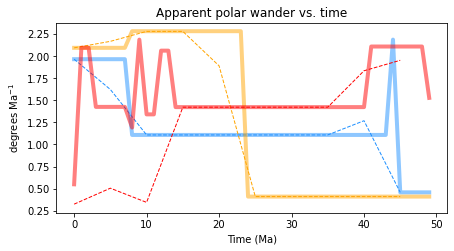

In [10]:
# generate apwps and compute apw rates
fig = plt.figure(figsize=fsize)
fast_apwps, fast_A95_paths = [], []
for i in range(len(pltids)):
    fast_apwp = af.get_apwp(time_range, time_step, pltids[i], rotation_model)
    fast_apwps.append(fast_apwp)
    fast_apw_rates, fast_low_res_rates, fast_avg_ages = [], [], []
    for j in range(len(fast_apwp)-1):
        fast_apw_rates.append(af.get_gcd(fast_apwp[j], fast_apwp[j+1])) # report in deg/Ma
    
    resolution = 5
    fast_low_res_apwp = fast_apwp[0::resolution]
    fast_A95_paths.append(fast_low_res_apwp)
    
    for j in range(len(fast_low_res_apwp)-1):
        fast_low_res_rates.append(af.get_gcd(fast_low_res_apwp[j], fast_low_res_apwp[j+1]) / resolution) # report in deg/Ma
        fast_avg_ages.append(j*resolution)
        
    plt.plot(fast_apw_rates, linestyle='solid', color=colors[i], linewidth=4, alpha=0.5)
    plt.plot(fast_avg_ages, fast_low_res_rates, linestyle='dashed', color=colors[i], linewidth=1)
    plt.title('Apparent polar wander vs. time')
    plt.ylabel('degrees Ma$^{-1}$')
    plt.xlabel('Time (Ma)')
    
plt.show()

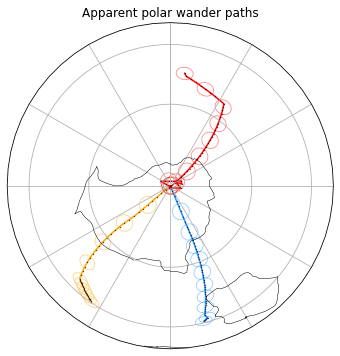

In [11]:
af.plot_apwps(central_lon=0, central_lat=90, polygons=plt_polygons, paths=fast_apwps, A95s=fast_A95_paths, colors=colors, title='Apparent polar wander paths')

### Data corruption

In [12]:
# add to the base rotation model
corr_rot_model = copy.deepcopy(base_rot_model)
corr_rot_model.append([1, 0, 0, 0, 0, 0])
corr_rot_model.append([1, time_range, 0, 0, 0, 0])

# write-out fast plate rotation model
with open('rot_models/corr_rot_model.rot', 'w') as f:
    for entry in corr_rot_model:
        f.write("%s\n" % ' '.join(map(str, entry)))

# re-open rotation model
current_rotation_features = pygp.FeaturesFunctionArgument('rot_models/corr_rot_model.rot')
current_rotation_model = pygp.RotationModel(current_rotation_features.get_features())

# generate corrupted direction histories
corr_events_list = []
corr_dirs_list = []
for i in range(3):
    #get random episodes of corruption
    corr_events_list.append(af.get_rand_ranges(min_time=0, max_time=time_range, min_events=0, max_events=4, min_duration=3, max_duration=16))
    
    #get random directions for each event
    corr_dirs = []
    for j in range(len(corr_events_list[i])):
        corr_lon = np.degrees(2*np.pi * np.random.rand())
        corr_lat = np.degrees(np.arcsin(np.random.rand()))

        # rotate corrupted direction according to base model (so that it is within 90 degrees of 'true' direction)
        corr_dir_feature = pygp.Feature()
        corr_dir_feature.set_geometry(pygp.PointOnSphere([corr_lat, corr_lon]))
        corr_dir_feature.set_reconstruction_plate_id(pltids[i])
        avg_corr_time = sum(corr_events_list[i][j])/2  # use the temporal mid-point of the corrupted age range
        rot_corr_dir_feature = []
        pygp.reconstruct(corr_dir_feature, current_rotation_model, rot_corr_dir_feature, avg_corr_time)
        rot_corr_dir = rot_corr_dir_feature[0].get_reconstructed_geometry().to_lat_lon()
        
        corr_dirs.append([rot_corr_dir[0], rot_corr_dir[1]])
        
    corr_dirs_list.append(corr_dirs)

# now build corrupted histories into rotation model
for i in range(3):
    reference_pos = pygp.PointOnSphere ([90, 0]) #(clocs[i])
    
    # interpolate rotation history in 1 Ma increments
    for j in range(0, time_range, 1):
        interpolated_rotation_features = af.interpolate_rot_model(current_rotation_features, pltids[i], j, 1)
        current_rotation_features = interpolated_rotation_features
    
    # corrupt history according to corrupted data
    for j in range(len(corr_events_list[i])):

        kappa = np.random.uniform(1000, 5000)
        for k in range(corr_events_list[i][j][0], corr_events_list[i][j][1]+1):
            
            # get slightly modified direction from reference remag direction
            new_dir = ipmag.fishrot(k=kappa, n=1, dec=corr_dirs_list[i][j][1], inc=corr_dirs_list[i][j][0])
            desired_pos = pygp.PointOnSphere(new_dir[0][1], new_dir[0][0])
  
            # update rotation sequence
            updated_rotation_features = af.update_rot_model(current_rotation_features, pltids[i], k, reference_pos, desired_pos)
            current_rotation_features = updated_rotation_features
            
corr_rot_model = pygp.RotationModel(current_rotation_features.get_features())    
        
# write-out fast plate rotation model
rotation_files = current_rotation_features.get_files()
if rotation_files:
    for feature_collection, filename in rotation_files:     
        feature_collection.write('rot_models/corr_rot_model.rot')

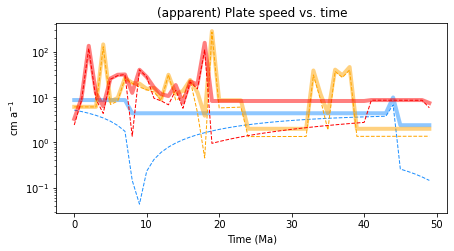

In [13]:
# re-import rotation model
rotation_model = pygp.RotationModel('rot_models/corr_rot_model.rot', default_anchor_plate_id=0)

# generate motion paths and compute plate drift rates
fig = plt.figure(figsize=fsize)
corr_motion_paths = []
for i in range(len(pltids)):
    corr_motion_path = af.get_motion_path(time_range, time_step, pltids[i], clocs[i], rotation_model)
    corr_motion_paths.append(corr_motion_path)
    corr_full_rates, corr_lat_rates = [], []
    for j in range(len(corr_motion_path)-1):
        corr_full_rates.append(af.get_gcd(corr_motion_path[j], corr_motion_path[j+1]) * 111 / (10*time_step)) # get gcd and convert from deg/Ma to cm/yr
        corr_lat_rates.append(abs(corr_motion_path[j][0]-corr_motion_path[j+1][0]) * 111 / (10*time_step))
    
    plt.plot(corr_full_rates, linestyle='solid', color=colors[i], linewidth=4, alpha=0.5)
    plt.plot(corr_lat_rates, linestyle='dashed', color=colors[i], linewidth=1)
    plt.yscale('log')
    #plt.ylim([10**-1, 10**3])
    plt.title('(apparent) Plate speed vs. time')
    plt.ylabel('cm a$^{-1}$')
    plt.xlabel('Time (Ma)')
    
plt.show()

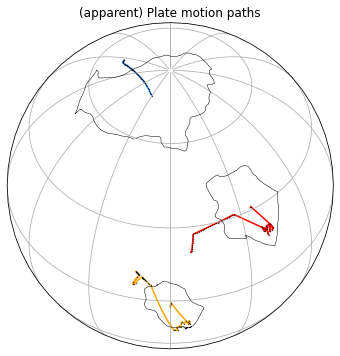

In [14]:
af.plot_motion_paths(central_lon=0, central_lat=45, polygons=plt_polygons, paths=corr_motion_paths, colors=colors, title='(apparent) Plate motion paths')

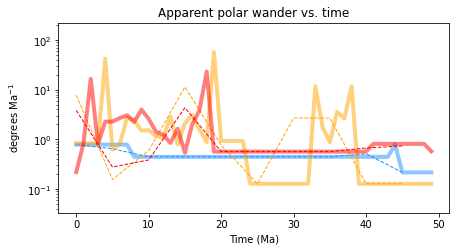

In [15]:
# generate apwps and compute apw rates
fig = plt.figure(figsize=fsize)
corr_apwps, corr_A95_paths = [], []
for i in range(len(pltids)):
    corr_apwp = af.get_apwp(time_range, time_step, pltids[i], rotation_model)
    corr_apwps.append(corr_apwp)
    corr_apw_rates, corr_low_res_rates, corr_avg_ages = [], [], []
    for j in range(len(corr_apwp)-1):
        corr_apw_rates.append(af.get_gcd(corr_apwp[j], corr_apwp[j+1])) # report in deg/Ma
    
    resolution = 5
    corr_low_res_apwp = corr_apwp[0::resolution]
    corr_A95_paths.append(corr_low_res_apwp)
    
    for j in range(len(corr_low_res_apwp)-1):
        corr_low_res_rates.append(af.get_gcd(corr_low_res_apwp[j], corr_low_res_apwp[j+1]) / resolution) # report in deg/Ma
        corr_avg_ages.append(j*resolution)
        
    plt.plot(corr_apw_rates, linestyle='solid', color=colors[i], linewidth=4, alpha=0.5)
    plt.plot(corr_avg_ages, corr_low_res_rates, linestyle='dashed', color=colors[i], linewidth=1)
    plt.yscale('log')
    plt.ylim([30**-1, 15**2])
    plt.title('Apparent polar wander vs. time')
    plt.ylabel('degrees Ma$^{-1}$')
    plt.xlabel('Time (Ma)')
    
plt.show()

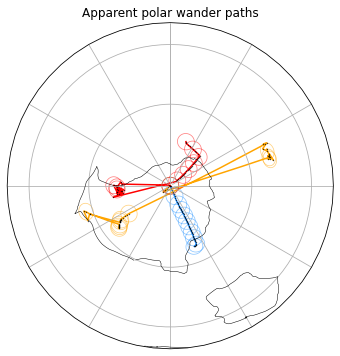

In [16]:
af.plot_apwps(central_lon=0, central_lat=90, polygons=plt_polygons, paths=corr_apwps, A95s=corr_A95_paths, colors=colors, title='Apparent polar wander paths')

### True polar wander

In [17]:
# TPW time range (in Ma)
tpw_onset = 50
tpw_cease = 0
tpw_lon = 90
tpw_max = 9
midpoint = tpw_cease + (tpw_onset-tpw_cease)/2
    
# add to the base rotation model
tpw_rot_model = copy.deepcopy(base_rot_model)

tpw_rot_model.append([1, 0, 0, 0, 0, 0])
tpw_rot_model.append([1, tpw_cease, 0, 0, 0, 0])

tpw_history = af.generate_tpw(midpoint, tpw_cease, tpw_lon, -tpw_max, 0, 1, 0)
for i in tpw_history: tpw_rot_model.append(i)

midmax = tpw_rot_model[-1][4]
tpw_history = af.generate_tpw(tpw_onset, midpoint, tpw_lon, tpw_max, midmax, 1, 0)
for i in tpw_history: tpw_rot_model.append(i)

tpw_rot_model.append([1, tpw_onset, 0, 0, 0, 0])
tpw_rot_model.append([1, time_range, 0, 0, 0, 0])

# write-out fast plate rotation model
with open('rot_models/tpw_rot_model.rot', 'w') as f:
    for entry in tpw_rot_model:
        f.write("%s\n" % ' '.join(map(str, entry)))

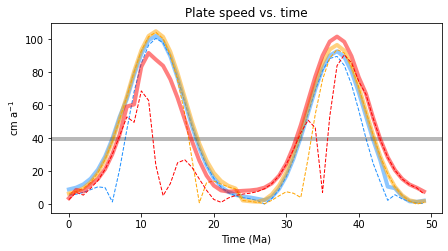

In [18]:
# re-import rotation model
rotation_model = pygp.RotationModel('rot_models/tpw_rot_model.rot', default_anchor_plate_id=0)

# generate motion paths and compute plate drift rates
fig = plt.figure(figsize=fsize)
tpw_motion_paths = []
for i in range(len(pltids)):
    tpw_motion_path = af.get_motion_path(time_range, time_step, pltids[i], clocs[i], rotation_model)
    tpw_motion_paths.append(tpw_motion_path)
    tpw_full_rates, tpw_lat_rates = [], []
    for j in range(len(tpw_motion_path)-1):
        tpw_full_rates.append(af.get_gcd(tpw_motion_path[j], tpw_motion_path[j+1]) * 111 / (10*time_step)) # get gcd and convert from deg/Ma to cm/yr
        tpw_lat_rates.append(abs(tpw_motion_path[j][0]-tpw_motion_path[j+1][0]) * 111 / (10*time_step))
    
    integrated_rate = abs(2*midmax/(tpw_onset-tpw_cease)*111/10)
    plt.axhline(y = integrated_rate, linestyle='solid', color='k', linewidth=4, alpha=0.1)
    plt.plot(tpw_full_rates, linestyle='solid', color=colors[i], linewidth=4, alpha=0.5)
    plt.plot(tpw_lat_rates, linestyle='dashed', color=colors[i], linewidth=1)
    plt.title('Plate speed vs. time')
    plt.ylabel('cm a$^{-1}$')
    plt.xlabel('Time (Ma)')
    
plt.show()

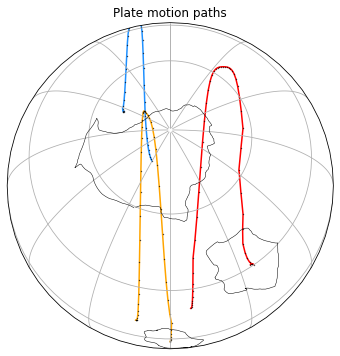

In [19]:
af.plot_motion_paths(central_lon=0, central_lat=70, polygons=plt_polygons, paths=tpw_motion_paths, colors=colors, title='Plate motion paths')

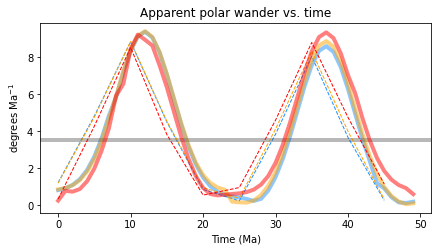

In [20]:
# generate apwps and compute apw rates
fig = plt.figure(figsize=fsize)
tpw_apwps, tpw_A95_paths = [], []
for i in range(len(pltids)):
    tpw_apwp = af.get_apwp(time_range, time_step, pltids[i], rotation_model)
    tpw_apwps.append(tpw_apwp)
    tpw_apw_rates, tpw_low_res_rates, tpw_avg_ages = [], [], []
    for j in range(len(tpw_apwp)-1):
        tpw_apw_rates.append(af.get_gcd(tpw_apwp[j], tpw_apwp[j+1])) # report in deg/Ma
    
    resolution = 5
    tpw_low_res_apwp = tpw_apwp[0::resolution]
    tpw_A95_paths.append(tpw_low_res_apwp)
    
    for j in range(len(tpw_low_res_apwp)-1):
        tpw_low_res_rates.append(af.get_gcd(tpw_low_res_apwp[j], tpw_low_res_apwp[j+1]) / resolution) # report in deg/Ma
        tpw_avg_ages.append(j*resolution)
        
    integrated_rate = abs(2*midmax/(tpw_onset-tpw_cease))
    plt.axhline(y = integrated_rate, linestyle='solid', color='k', linewidth=4, alpha=0.1)
    plt.plot(tpw_apw_rates, linestyle='solid', color=colors[i], linewidth=4, alpha=0.5)
    plt.plot(tpw_avg_ages, tpw_low_res_rates, linestyle='dashed', color=colors[i], linewidth=1)
    plt.title('Apparent polar wander vs. time')
    plt.ylabel('degrees Ma$^{-1}$')
    plt.xlabel('Time (Ma)')
    
plt.show()

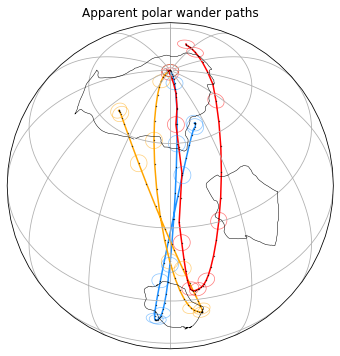

In [21]:
af.plot_apwps(central_lon=0, central_lat=45, polygons=plt_polygons, paths=tpw_apwps, A95s=tpw_A95_paths, colors=colors, title='Apparent polar wander paths')

### Anomalous magnetic field

In [22]:
# equatorial dipole time range (in Ma)
eqdi_on = 34.5
eqdi_off = 15.5
transition = 0.5

# add to the base rotation model
eqdi_rot_model = copy.deepcopy(base_rot_model)
eqdi_rot_model.append([1, 0, 0, 0, 0, 0])
eqdi_rot_model.append([1, eqdi_off, 0, 0, 0, 0])
eqdi_rot_model.append([1, eqdi_off+transition, 0, 90, -90, 0])
eqdi_rot_model.append([1, eqdi_on+transition, 0, 90, -90, 0])
eqdi_rot_model.append([1, eqdi_on, 0, 0, 0, 0])
eqdi_rot_model.append([1, time_range, 0, 0, 0, 0])

# write-out fast plate rotation model
with open('rot_models/eqdi_rot_model.rot', 'w') as f:
    for entry in eqdi_rot_model:
        f.write("%s\n" % ' '.join(map(str, entry)))

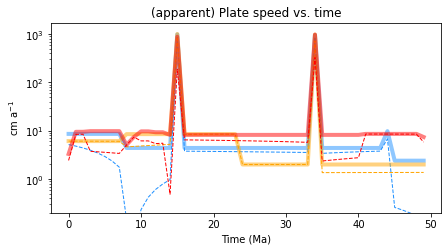

In [23]:
# re-import rotation model
rotation_model = pygp.RotationModel('rot_models/eqdi_rot_model.rot', default_anchor_plate_id=0)

# generate motion paths and compute plate drift rates
fig = plt.figure(figsize=fsize)
eqdi_motion_paths = []
for i in range(len(pltids)):
    eqdi_motion_path = af.get_motion_path(time_range, time_step, pltids[i], clocs[i], rotation_model)
    eqdi_motion_paths.append(eqdi_motion_path)
    eqdi_full_rates, eqdi_lat_rates = [], []
    for j in range(len(eqdi_motion_path)-1):
        eqdi_full_rates.append(af.get_gcd(eqdi_motion_path[j], eqdi_motion_path[j+1]) * 111 / (10*time_step)) # get gcd and convert from deg/Ma to cm/yr
        eqdi_lat_rates.append(abs(eqdi_motion_path[j][0]-eqdi_motion_path[j+1][0]) * 111 / (10*time_step))
    
    plt.plot(eqdi_full_rates, linestyle='solid', color=colors[i], linewidth=4, alpha=0.5)
    plt.plot(eqdi_lat_rates, linestyle='dashed', color=colors[i], linewidth=1)
    plt.yscale('log')
    plt.ylim([5**-1, 12**3])
    plt.title('(apparent) Plate speed vs. time')
    plt.ylabel('cm a$^{-1}$')
    plt.xlabel('Time (Ma)')
    
plt.show()

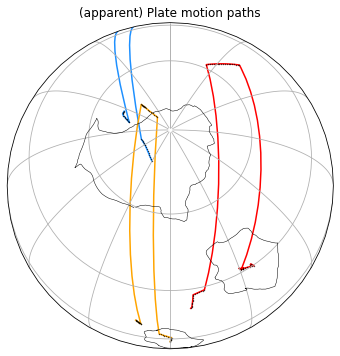

In [24]:
af.plot_motion_paths(central_lon=0, central_lat=70, polygons=plt_polygons, paths=eqdi_motion_paths, colors=colors, title='(apparent) Plate motion paths')

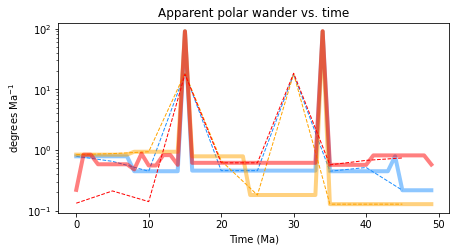

In [25]:
# generate apwps and compute apw rates
fig = plt.figure(figsize=fsize)
eqdi_apwps, eqdi_A95_paths = [], []
for i in range(len(pltids)):
    eqdi_apwp = af.get_apwp(time_range, time_step, pltids[i], rotation_model)
    eqdi_apwps.append(eqdi_apwp)
    eqdi_apw_rates, eqdi_low_res_rates, eqdi_avg_ages = [], [], []
    for j in range(len(eqdi_apwp)-1):
        eqdi_apw_rates.append(af.get_gcd(eqdi_apwp[j], eqdi_apwp[j+1])) # report in deg/Ma
    
    resolution = 5
    eqdi_low_res_apwp = eqdi_apwp[0::resolution]
    eqdi_A95_paths.append(eqdi_low_res_apwp)
    
    for j in range(len(eqdi_low_res_apwp)-1):
        eqdi_low_res_rates.append(af.get_gcd(eqdi_low_res_apwp[j], eqdi_low_res_apwp[j+1]) / resolution) # report in deg/Ma
        eqdi_avg_ages.append(j*resolution)
        
    plt.plot(eqdi_apw_rates, linestyle='solid', color=colors[i], linewidth=4, alpha=0.5)
    plt.plot(eqdi_avg_ages, eqdi_low_res_rates, linestyle='dashed', color=colors[i], linewidth=1)
    plt.yscale('log')
    #plt.ylim([20**-1, 15**2])
    plt.title('Apparent polar wander vs. time')
    plt.ylabel('degrees Ma$^{-1}$')
    plt.xlabel('Time (Ma)')
    
plt.show()

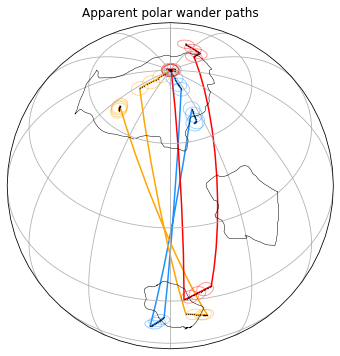

In [26]:
af.plot_apwps(central_lon=0, central_lat=45, polygons=plt_polygons, paths=eqdi_apwps, A95s=eqdi_A95_paths, colors=colors, title='Apparent polar wander paths')